# Topic - Sentiment Distribution and Extremes Analysis

This notebook accomplishes the following tasks:
1. perform LDA theme modeling on tweets
2. Analyze the sentiment distribution under each topic
3. Identify extreme sentiment topics
4. Visualize the analysis results

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
warnings.filterwarnings('ignore')


In [9]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

df = pd.read_csv("../2_data/cleaned_nvda.csv", parse_dates=["created_at"])
df["clean_tweet"] = df["body"].fillna("").astype(str)  # 假设文本字段叫 body

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# add financial-specific stop words
financial_stop_words = {'stock', 'market', 'price', 'trading', 'trade', 'investor', 'investment', 
                       'nvda', 'nvidia', 'share', 'shares', 'buy', 'sell', 'hold', 'bullish', 
                       'bearish', 'chart', 'technical', 'analysis', 'fundamental', 'earnings', 
                       'quarter', 'report', 'financial', 'company', 'firm', 'business', 'stock', 
                       'market', 'price', 'trading', 'trade', 'investor', 'investment', 'nvda', 
                       'nvidia', 'share', 'shares', 'buy', 'sell', 'hold', 'bullish', 'bearish', 
                       'chart', 'technical', 'analysis', 'fundamental', 'earnings', 'quarter', 
                       'report', 'financial', 'company', 'firm', 'business'}
stop_words.update(financial_stop_words)

# text preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

df['processed_text'] = df['clean_tweet'].apply(preprocess_text)
print(df['processed_text'].head())

[nltk_data] Downloading package punkt to /Users/q/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/q/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0            shorts using lot ammo trying keep working
1            quite rebound today hardly believe seeing
2    said week ago would point start returning cash...
3    shorting like picking dimes front bulldozer fo...
4                  good job fighting shorts break soon
Name: processed_text, dtype: object


In [10]:
print(f"Total tweets: {len(df)}")
print("\nExample processed tweets:")
print(df['processed_text'].head())

Total tweets: 501908

Example processed tweets:
0            shorts using lot ammo trying keep working
1            quite rebound today hardly believe seeing
2    said week ago would point start returning cash...
3    shorting like picking dimes front bulldozer fo...
4                  good job fighting shorts break soon
Name: processed_text, dtype: object


## 2. LDA theme modeling

In [13]:
import pandas as pd

df = pd.read_csv("../2_data/tweet_level_sentiment.csv")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# 可选：添加金融领域停用词
financial_stop_words = {'stock', 'market', 'price', 'trading', 'trade', 'investor', 'investment', 
                       'nvda', 'nvidia', 'share', 'shares', 'buy', 'sell', 'hold', 'bullish', 
                       'bearish', 'chart', 'technical', 'analysis', 'fundamental', 'earnings', 
                       'quarter', 'report', 'financial', 'company', 'firm', 'business'}
stop_words.update(financial_stop_words)

def preprocess_text(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

df['processed_text'] = df['Cleaned_Tweet'].apply(preprocess_text)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['processed_text'])

n_topics = 8  # 你可以根据需要调整主题数

lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method='online',
    random_state=42,
    batch_size=128,
    verbose=0
)

topic_distribution = lda.fit_transform(X)
df['topic'] = topic_distribution.argmax(axis=1)

feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

print("Keywords for each topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


    topic_sentiment_stats = df.groupby('topic')['sentiment_score'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: (x > 0.5).mean(),   # high positive sentiment ratio
    lambda x: (x < -0.5).mean()   # high negative sentiment ratio
]).round(4)
topic_sentiment_stats.columns = [
    'number of tweets', 'Avg Sentiment', 'standard deviation', 'Min', 'Max',
    'High positive ratio', 'High negative ratio'
]
print(topic_sentiment_stats)

df.to_csv("../2_data/tweets_with_topics.csv", index=False)


[nltk_data] Downloading package punkt to /Users/q/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/q/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Keywords for each topic:
Topic 1: shorts, new, support, break, split, higher, 50, daily, hours, level
Topic 2: green, long, short, got, way, coming, drop, today, wow, wait
Topic 3: week, good, lets, know, looking, holding, red, big, selling, end
Topic 4: amd, bears, money, intc, 300, 200, tech, make, 250, good
Topic 5: rocket, think, going, dont, money_bag, people, it39s, bad, need, let
Topic 6: aapl, tsla, amzn, buying, nflx, bought, amd, msft, great, face_with_tears_of_joy
Topic 7: spy, lol, qqq, amd, bulls, bull, news, today, like, china
Topic 8: calls, tomorrow, today, day, puts, like, close, time, dip, nice
       number of tweets  Avg Sentiment  standard deviation  Min  Max  \
topic                                                                  
0                 58173         0.0166              0.2038 -1.0  1.0   
1                 56501         0.0284              0.2345 -1.0  1.0   
2                 56768         0.0304              0.2486 -1.0  1.0   
3                 56


## 3. Theme-sentiment distribution analysis

In [18]:
print(df['sentiment_score'].value_counts())
print(df['sentiment_score'].unique())

sentiment_score
 0.000000    225437
 1.000000     18116
 0.027525      9133
 0.022575      7459
-1.000000      7271
              ...  
-0.052831         1
-0.005731         1
-0.041981         1
 0.054913         1
-0.051206         1
Name: count, Length: 9688, dtype: int64
[-1.          0.          1.         ... -0.06179375 -0.05143125
 -0.05120625]


       number of tweets  Avg Sentiment  standard deviation  Min  Max  \
topic                                                                  
0                 58173         0.0166              0.2038 -1.0  1.0   
1                 56501         0.0284              0.2345 -1.0  1.0   
2                 56768         0.0304              0.2486 -1.0  1.0   
3                 56546         0.0486              0.2705 -1.0  1.0   
4                 46501         0.0176              0.2454 -1.0  1.0   
5                 57579         0.0327              0.2176 -1.0  1.0   
6                 48935         0.0164              0.2210 -1.0  1.0   
7                 84022         0.0242              0.2214 -1.0  1.0   

       High positive ratio  High negative ratio  
topic                                            
0                   0.0152               0.0068  
1                   0.0211               0.0084  
2                   0.0236               0.0098  
3                   0.0321   

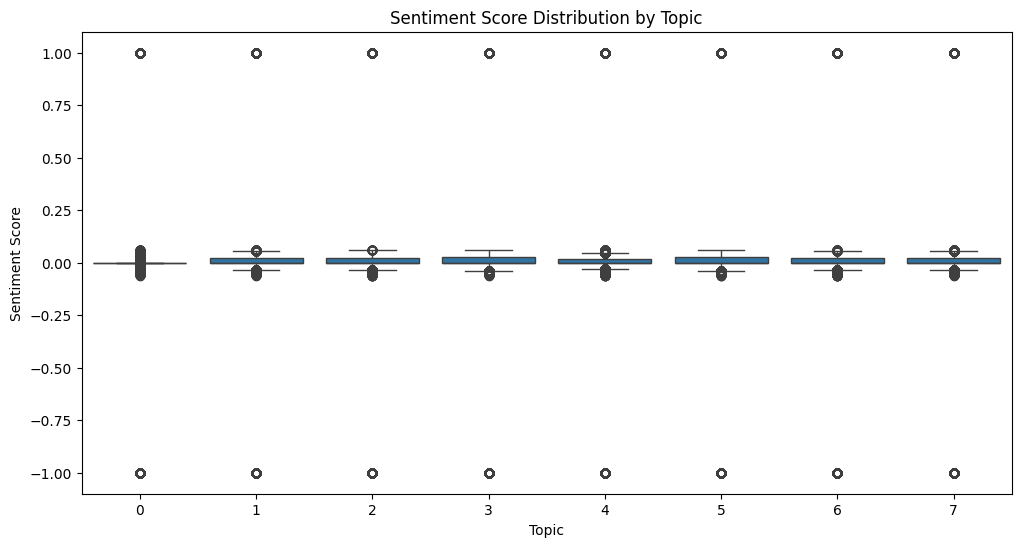

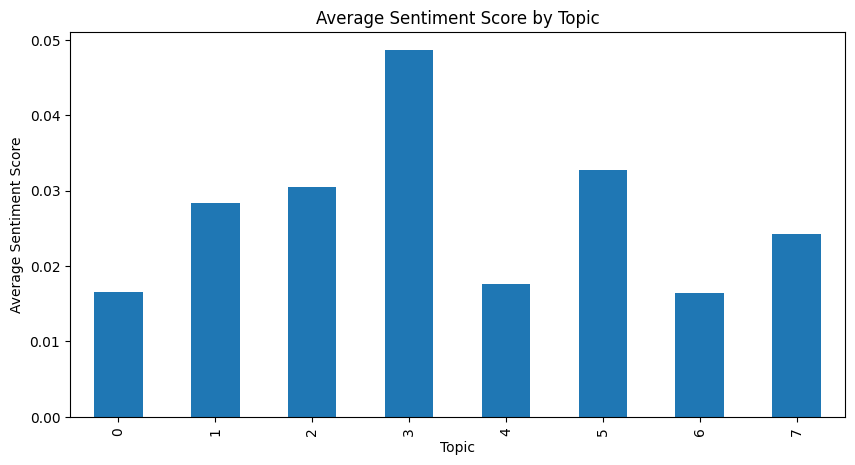

In [19]:
import pandas as pd

df = pd.read_csv("../2_data/tweets_with_topics.csv")

topic_sentiment_stats = df.groupby('topic')['sentiment_score'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: (x > 0.5).mean(),   # high positive sentiment ratio
    lambda x: (x < -0.5).mean()   # high negative sentiment ratio
]).round(4)

topic_sentiment_stats.columns = [
    'number of tweets', 'Avg Sentiment', 'standard deviation', 'Min', 'Max',
    'High positive ratio', 'High negative ratio'
]

print(topic_sentiment_stats)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='topic', y='sentiment_score', data=df)
plt.title('Sentiment Score Distribution by Topic')
plt.xlabel('Topic')
plt.ylabel('Sentiment Score')
plt.show()


plt.figure(figsize=(10, 5))
topic_sentiment_stats['Avg Sentiment'].plot(kind='bar')
plt.title('Average Sentiment Score by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.show()

topic_sentiment_stats.to_csv("../2_data/topic_sentiment_stats.csv")



- The number of tweets per topic is relatively balanced, ranging from 46,501 to 84,022. This indicates a well-distributed LDA topic modeling, with Topic 7 being the largest and Topic 4 the smallest

1. Topics:
- All topics show average sentiment scores close to zero, with Topic 3 being the most positive and Topic 6 the least.
- Standard deviations suggest moderate variation around neutral sentiment.
- All topics span the full range of [-1, 1], indicating presence of extreme sentiments across topics.

2. Percentage of extreme emotional tweets
- High positive (> 0.5): 1.5% ~ 3.2%, up to Topic 3. Percentage of extreme emotional tweets
- Percentage of highly negative (< -0.5) tweets: 0.56% ~ 1.17%, with topic 4 being the highest.
- Extreme sentiment tweets are rare, and most of them are mild and rational.
Extreme sentiment tweets are rare across all topics, mostly staying in mild emotional ranges.

4. Visualization Findings
- Boxplots show tight emotional ranges across topics with a few outliers. bar plots of average sentiment confirm overall neutrality with slight variation .



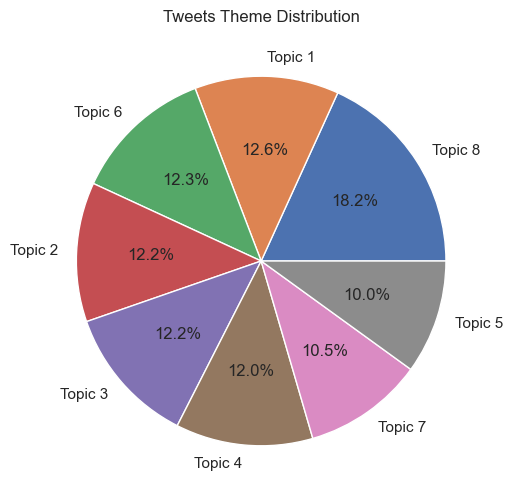

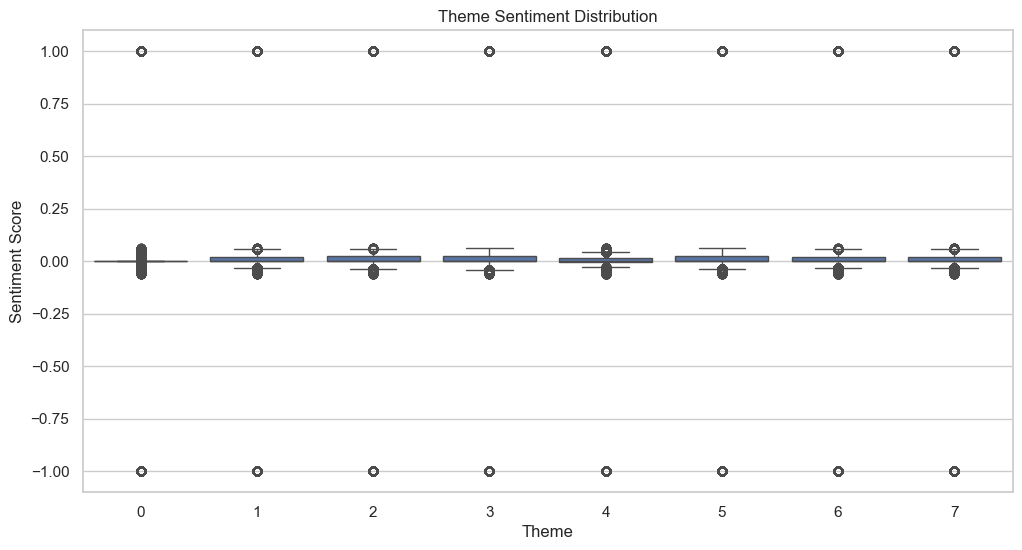

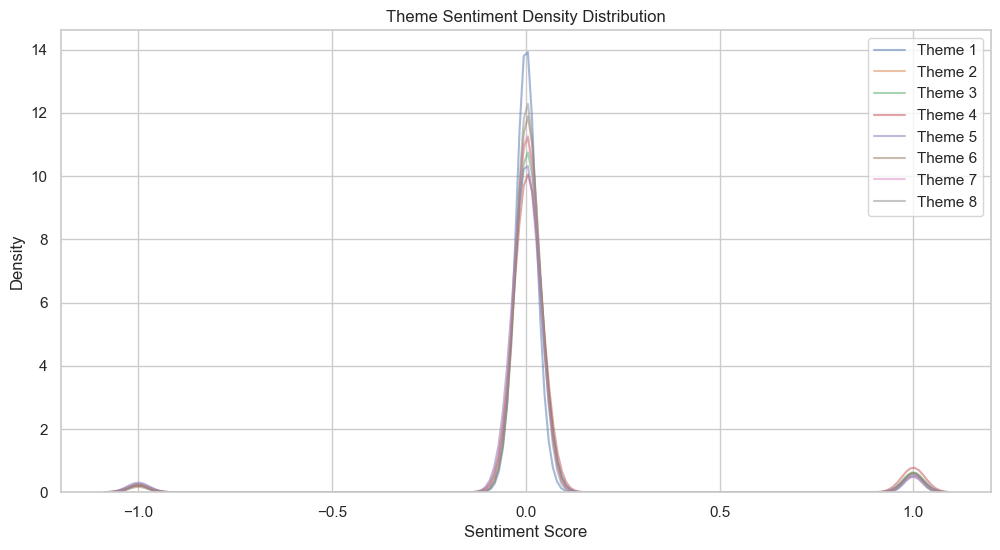

In [22]:
import seaborn as sns
sns.set_theme(style="whitegrid")  

# 1. Thematic Distribution Pie Chart
plt.figure(figsize=(12, 6))
topic_counts = df['topic'].value_counts()
plt.pie(topic_counts, labels=[f'Topic {i+1}' for i in topic_counts.index], autopct='%1.1f%%')
plt.title('Tweets Theme Distribution')
plt.show()

# 2. Theme Sentiment Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='topic', y='sentiment_score', data=df)
plt.title('Theme Sentiment Distribution')
plt.xlabel('Theme')
plt.ylabel('Sentiment Score')
plt.show()

# 3. Theme Sentiment Density Plot
plt.figure(figsize=(12, 6))
n_topics = df['topic'].nunique()
for topic in range(n_topics):
    sns.kdeplot(data=df[df['topic'] == topic]['sentiment_score'], 
                label=f'Theme {topic+1}', alpha=0.5)
plt.title('Theme Sentiment Density Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

**Theme-sentiment Analysis Summary**: The LDA topic model resulted in a well-balanced theme distribution. Regardless of topic, tweet sentiment is overwhelmingly neutral with only minimal emotional polarization. The consistency of boxplots and density curves suggests that users express emotions similarly across different themes, and that extreme sentiment is rare across the dataset.




1. Tweets Theme Distribution (Pie Chart)
- Overall Balance: The distribution of tweet topics is relatively balanced. Except for Topic 8 (18.2%), all other topics account for approximately 10%–13% of total tweets.

- opic 8 Stands Out: Topic 8 has a notably higher share, suggesting it may cover broader or more popular content themes compared to the others.

2. Theme Sentiment Distribution (Boxplot)
- Highly Concentrated Sentiment: Across all topics, sentiment scores are tightly clustered around neutral (0). Most tweets fall within a narrow range of –0.1 to 0.1, indicating that neutral sentiment dominates.
- Presence of Extremes: Each topic includes a few outliers at –1 and +1, representing extreme negative and positive sentiments. However, these are rare, confirming that extreme emotional tweets are not mainstream.
- Similar Shapes Across Topics: The boxplots show almost identical distribution shapes across themes, implying no significant sentiment polarization between topics.


3. Theme Sentiment Density Distribution (KDE Plot)
- Sharp Peak at Neutral (0): All topics exhibit a high density peak near zero, confirming again that most tweets are emotionally neutral.
- Tiny Secondary Peaks at Extremes: Minor density bumps at –1 and +1 reflect the existence of extreme sentiment tweets, though they constitute only a very small fraction.
- Near-Overlapping Distributions: The sentiment curves for all themes almost completely overlap, showing no substantial inter-topic variation in sentiment.



## 5. Extreme emotion topic analysis

In [24]:
print(df.columns)

Index(['Date', 'Cleaned_Tweet', 'sentiment_score', 'sentiment_label',
       'category', 'processed_text', 'topic'],
      dtype='object')


In [25]:
# Find the most extreme topic
most_positive_topic = topic_sentiment_stats['Avg Sentiment'].idxmax()
most_negative_topic = topic_sentiment_stats['Avg Sentiment'].idxmin()

print(f"Most positive theme (Theme {most_positive_topic + 1}):")
print(f"Average sentiment score: {topic_sentiment_stats.loc[most_positive_topic, 'Avg Sentiment']:.4f}")
print(f"High positive sentiment ratio: {topic_sentiment_stats.loc[most_positive_topic, 'High positive ratio']:.2%}")
print("\nExample tweets from this theme:")
print(df[df['topic'] == most_positive_topic]['Cleaned_Tweet'].head())

print(f"\nMost negative theme (Theme {most_negative_topic + 1}):")
print(f"Average sentiment score: {topic_sentiment_stats.loc[most_negative_topic, 'Avg Sentiment']:.4f}")
print(f"High negative sentiment ratio: {topic_sentiment_stats.loc[most_negative_topic, 'High negative ratio']:.2%}")
print("\nExample tweets from this theme:")
print(df[df['topic'] == most_negative_topic]['Cleaned_Tweet'].head())

Most positive theme (Theme 4):
Average sentiment score: 0.0486
High positive sentiment ratio: 3.21%

Example tweets from this theme:
4     $nvda if you must own chip stock i would buy $...
6     $nvda progrm made in python which can determin...
13    keeping my eye on $nvda $amd $twlo for some te...
20    our algorithm picked $nvda the last three mont...
23    bradams $nvda i agree seeking alpha has an age...
Name: Cleaned_Tweet, dtype: object

Most negative theme (Theme 7):
Average sentiment score: 0.0164
High negative sentiment ratio: 0.93%

Example tweets from this theme:
16    $amd $nvda anyone concerned with rotation to o...
22    $nvda futures fair value dow up 100,still bear...
27    very hype at the moment, but watching $nvda $t...
31    $nvda $amd lots of bearish news for the semi c...
39    hey there boys amp girls! it39s semiconductor ...
Name: Cleaned_Tweet, dtype: object




- Most positive theme (Theme 4):

- Average sentiment score: 0.0486

- High positive sentiment ratio: 3.21%

- Example tweets show a focus on positive outlooks for $NVDA, algorithmic picks, and agreement with optimistic analysis.

- Most negative theme (Theme 7):

- Average sentiment score: 0.0164

- High negative sentiment ratio: 0.93%

- Example tweets reflect concerns about the semiconductor sector, bearish news, and cautious or negative sentiment towards $NVDA and related stocks.

Conclusion:

The overall sentiment across themes is relatively neutral, with only slight differences between the most positive and most negative themes. Even the most negative theme has a low negative sentiment ratio, indicating that extreme sentiment is rare in the dataset. Most discussions are rational and balanced.